# <center>Bad Bank Behavior<br>Analyzing Bank Mortgage during the 2007 Housing Bubble</center>  

<center>Michael Siebel</center>
<center>August 2020</center>

<br>
    
## Table of Contents
- [Goals](#Goals)<br>
- [Load Packages](#Load-Packages)<br>
- [Set Up Functions](#Set-Up-Functions)<br>
- [Implement Data Cleanings](#Implement-Data-Cleanings)<br>
- [Analysis Functions](#Analysis-Functions)<br>
- [Imbalanced Prediction](#Imbalanced-Prediction)
- [Downsampling Prediction](#Downsampling-Prediction)<br>
- [Upsampling Prediction](#Upsampling-Prediction)<br>
- [Conclusion](#Conclusion)<br>

# Goals  
<br>

 

***

# Load Packages

In [1]:
# Core Packages
import pandas as pd
import numpy as np
import random
import glob
# Convert Time Features
from datetime import datetime as dt
# Data Visualizations
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', grid=False)
# Imputing Data
from sklearn.impute import KNNImputer
# Splitting Data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Machine Learning Packages
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Save Runtime
import time
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Output Statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

***

# Set Up Functions  
<br>

In this post, I set up all data wrangling and data analysis as a series of functions, which will enable me to reuse on data from subsequent years (future projects) and various analysis techniques (this project).

### Fannie Mae data comes in two forms:  
### 1) acquistion data and 2) performance data  
<br>
1) The acquisition data includes one observation for each loan with each feature representing knowledge Fannie Mae has when acquiring the loan (e.g., balance, primary lender, credit score, etc.).  

2) The performance data includes observations for each month each loan is held and information on the payment of the loan.  
<br>
I use the acquisition data as predictors for a dichotomous categorization of whether the homeowner defaulted on their loan, a target variable I create using the performance data and merging onto the acquisition data.  

In [2]:
# Load the data
def load_data(acq, per):
    df_acq = pd.read_csv(acq, sep='|', header=None)
    df_per = pd.read_csv(per, sep='|', header=None)
    
    # Specify the name of the columns
    df_acq.columns = ['Loan ID','Origination Channel','Bank','Original Interest Rate',
                      'Original Mortgage Amount','Original Loan Term','Original Date','First Payment',
                      'Original Loan-to-Value (LTV)','Original Combined Loan-to-Value (CLTV)',
                      'Number of Borrowers','Original Debt to Income Ratio','Credit Score',
                      'First Time Home Buyer','Loan Purpose','Property Type','Number of Units',
                      'Occupancy Type','Property State','Zip Code','Mortgage Insurance %',
                      'Product Type','Co-Borrower Credit Score','Mortgage Insurance Type',
                      'Relocation Mortgage Indicator']
    
    df_per.columns = ['Loan ID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','Foreclosure Date','DispositionDate','FCCCost','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator']
    
    return df_acq, df_per

Performance data is much larger as it is transaction based, while the acquistion data has the loan owner as its unit of analysis.  
<br>
I retain only the most recent performance transaction relating to foreclosure, then drop all other variables except  Loan ID (the primary key) and merge performance data onto acquisition data.  
<br>
I recode performance data into dichotomous categorization of whether loan was foreclosed upon.

In [3]:
# Merge foreclosures from performance data to acquistion data
def merge_df(df_acq, df_per):
    
    # Columns to maintain from Performance Data
    per_ColKeep = ['Loan ID','Foreclosure Date']
    df_per = df_per[per_ColKeep]
    df_per = df_per.drop_duplicates(subset='Loan ID', keep='last')
    df = pd.merge(df_acq, df_per, on='Loan ID', how='inner')
    
    # Set Foreclosed to binary
    df.loc[df['Foreclosure Date'].isnull(), 'Foreclosed'] = 0
    df.loc[df['Foreclosure Date'].notnull(),'Foreclosed'] = 1
    df = df.drop(columns='Foreclosure Date')
    df['Foreclosed'] = df['Foreclosed'].astype(int)
    
    # Drop mergeID column
    df = df.drop(df.columns[[0]], axis=1)
    
    return df

I remove features with really high missingness or no data variation, and then impute on features with low missingness

In [100]:
def missing_treat(df):
    # Find features with 10% missing or more
    # condition = ( df.isnull().sum(axis=0)/df.shape[0]*100 ) 
    # df_HighMissing = condition > 10 
    
    # Save features that contain missing data
    # df_HighMissing = df_HighMissing.index[df_HighMissing.values == True]
    
    # remove high missing features
    # df = df.drop(labels=df_HighMissing, axis=1)
    
    # remove Product Type, it only had one value    
    # df = df.drop(labels=['Product Type'], axis=1)
    
    # remove Original Loan-to-Value (LTV) and use Original Combine Loan-to-Value (CLTV)
    df = df.drop(labels=['Original Loan-to-Value (LTV)'], axis=1)
        
    # remove First Payment as this is of no value
    df = df.drop(labels=['First Payment'], axis=1)
        
    # impute on the mean for low missing features that are continuous   
    df_cont = df.select_dtypes(include=['float64', 'int64'])
    df[df_cont.columns] = df_cont.apply(lambda x: x.fillna(x.mean()),axis=0)
    
    # impute on the mode for low missing features that are categorical   
    df_cat = df.select_dtypes(include=['object'])
    df[df_cat.columns] = df_cat.apply(lambda x: x.fillna(x.mode()),axis=0)  
    
    # impute using KNN
    # KNN_impute = KNNImputer(n_neighbors=2, weights="uniform")
    # df = KNN_impute.fit_transform(df)
    
    return df

Changing date features to numeric

In [5]:
# Changing date features to ordinal variables using the function toordinal()
def change_date(df):
    
    # Origination Date
    df['Original Date'] = df['Original Date'].apply(lambda x: dt.strptime(x, '%m/%Y').toordinal())
    
    # Date of First Payment
    # df['FirstPayment'] = df['FirstPayment'].apply(lambda x: dt.strptime(x, '%m/%Y').toordinal())
    
    return df

One Hot Encoding

In [6]:
# Converting categorical variables to dummy variables
def onehotencoding(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df = df.drop(nan_cols.columns, axis=1)

    df_cat = df.select_dtypes(include=['object'])
    onehot = pd.get_dummies(df_cat)
    
    df_cont = df.drop(df_cat.columns, axis=1)

    df = pd.concat([df_cont,onehot,nan_cols], axis=1).reset_index(drop=True)
    return df

Function to plot target variable

In [7]:
# Check the percentage and frequency of target variable
def target_values(df_depvar, data=False, prediction=False):
        
    # save target frequencies
    target_frequency = df_depvar.value_counts()
        
    # save target percentage
    target_percentage = round((df_depvar.value_counts()/df_depvar.count())*100).astype(int)
        
    # graphing target variable
    jtplot.style(ticks=True, grid=False)
    plt.figure(figsize=(14,4))
    target_percentage.plot.barh(stacked=True, color='#ca2c92').invert_yaxis()
    if data:
        plt.suptitle('Bar Chart of Target Variable', fontsize=18)
    elif prediction:
        plt.suptitle('Bar Chart of Predictions', fontsize=18)
    else:
        plt.suptitle('Percent of Mortage Defaults', fontsize=18)
    plt.ylabel('Foreclosed')
    plt.xlabel('Percentage')
    plt.xlim([0,100])
    # plt.yticks([0, 1], ['Did not Foreclose', 'Foreclosed'])
    plt.show()
    
    # display frequency of foreclosures
    print('Frequency of Foreclosures\n', target_frequency, '\n', sep='')
    
    # display percentage of foreclosures
    print('Percentage of Foreclosures\n', target_percentage, '\n', sep='')

***

# Implement Data Cleanings

In [8]:
# Import packages
import os
import glob

# Collect file names
fld = 'C:/Users/siebe/Documents/03_GWU/10 Capstone/Data/'
x = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Acquisition_2007Q"): 
        x.append(fld + filename)
        
y = []
for file in os.listdir(fld):
    filename = os.fsdecode(file)
    if filename.startswith("Performance_2007Q"): 
        y.append(fld + filename)

# Load data
df_acq = pd.DataFrame()
df_per = pd.DataFrame()
for i in range(len(x)):
    acq, per = load_data(x[i], y[i])
    acq['Year'], per['Year'] = x[i][12:16], x[i][12:16]
    acq['Quarter'], per['Quarter'] = x[i][16:18], x[i][16:18]
    df_acq = pd.concat([df_acq, acq],ignore_index=True)
    df_per = pd.concat([df_per, per],ignore_index=True)

                           

In [9]:
# Shape
df_acq.shape

(1246499, 27)

In [10]:
# Dates
df_acq['Original Date'].value_counts()

10/2007    118132
05/2007    114831
06/2007    109068
08/2007    107989
09/2007    101153
            ...  
04/2000         1
10/2000         1
07/2000         1
08/2000         1
07/1999         1
Name: Original Date, Length: 101, dtype: int64

In [11]:
# Co-Borrower Credit Score
df_acq['Harmonized Credit Score'] = ( df_acq['Co-Borrower Credit Score'][df_acq['Co-Borrower Credit Score'].notnull()] * 0.25 ) \
                                  + ( df_acq['Credit Score'][df_acq['Co-Borrower Credit Score'].notnull()] * 0.75 ) 
df_acq['Harmonized Credit Score'][df_acq['Co-Borrower Credit Score'].isnull()] = df_acq['Credit Score'][df_acq['Co-Borrower Credit Score'].isnull()]    

print(df_acq[['Harmonized Credit Score', 'Credit Score', 'Co-Borrower Credit Score']].head(10))
df_acq = df_acq.drop(labels=['Co-Borrower Credit Score'], axis = 1)

c:\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


   Harmonized Credit Score  Credit Score  Co-Borrower Credit Score
0                   739.25         741.0                     734.0
1                   787.50         796.0                     762.0
2                   710.00         710.0                       NaN
3                   747.50         778.0                     656.0
4                   715.00         720.0                     700.0
5                   750.50         753.0                     743.0
6                   696.25         674.0                     763.0
7                   749.00         749.0                       NaN
8                   777.00         777.0                       NaN
9                   619.00         619.0                       NaN


In [12]:
# Mortgage Insurance %
df_acq['Mortgage Insurance %'] = np.where(df_acq['Mortgage Insurance %'].isnull(), \
                                             0, df_acq['Mortgage Insurance %'])
df_acq['Mortgage Insurance Type'][df_acq['Mortgage Insurance %']==0].value_counts()

Series([], Name: Mortgage Insurance Type, dtype: int64)

In [13]:
# Mortgage Insurance Type
df_acq['Mortgage Insurance Type'] = np.where(df_acq['Mortgage Insurance Type'].isnull(), \
                                             0, 1)
df_acq['Mortgage Insurance Type'].value_counts()

0    1030027
1     216472
Name: Mortgage Insurance Type, dtype: int64

In [14]:
# Recode Number of Borrowers
# Single Borrower binary
# More than one borrower is 0
df_acq['Number of Borrowers'] = df_acq['Number of Borrowers'].where(df_acq['Number of Borrowers'] == 1, 0)
df_acq = df_acq.rename(columns={'Number of Borrowers': 'Single Borrower'})
df_acq['Single Borrower'].value_counts()

0.0    669043
1.0    577456
Name: Single Borrower, dtype: int64

In [15]:
# Import zipcode median household income
income = pd.read_excel("C:/Users/siebe/Documents/03_GWU/10 Capstone/Data/est07all.xls",
                       sheet_name = 'est07ALL', header = 2)
income = income[['Name', 'Median Household Income']]
income = income.rename(columns={'Name': 'County'})

# Import county zipcode crosswalk
crosswalk = pd.read_csv("C:/Users/siebe/Documents/03_GWU/10 Capstone/Data/ZIP-COUNTY-FIPS_2017-06.csv",
                        header = 0)
crosswalk = crosswalk[['ZIP', 'COUNTYNAME']]
crosswalk = crosswalk.rename(columns={'ZIP': 'Zip Code', 'COUNTYNAME': 'County'})
crosswalk['Zip Code'] = crosswalk['Zip Code'].astype(str)
crosswalk['Zip Code'] = crosswalk['Zip Code'].str.slice(start=0, stop=-2)
crosswalk['Zip Code'] = crosswalk['Zip Code'].astype(int)

# Merge
income_zipcode = pd.merge(income, crosswalk, on='County', how='outer')
income_zipcode.head(10)

,County,Median Household Income,Zip Code
0,United States,50740.0,NaN
1,Alabama,40596.0,NaN
2,Autauga County,50375.0,360.0
3,Autauga County,50375.0,360.0
4,Autauga County,50375.0,360.0
5,Autauga County,50375.0,360.0
6,Autauga County,50375.0,367.0
7,Autauga County,50375.0,367.0
8,Autauga County,50375.0,360.0
9,Autauga County,50375.0,360.0


In [16]:
# Merge zipcode crosswalk with 
income_zipcode = income_zipcode[['Median Household Income', 'Zip Code']]
income_zipcode = income_zipcode.groupby('Zip Code').agg({'Median Household Income': 'mean'})
df_acq = pd.merge(df_acq, income_zipcode, on='Zip Code', how='left')

df_acq['Median Household Income'].describe()

count    1.240937e+06
mean     4.824204e+04
std      8.481130e+03
min      2.883194e+04
25%      4.307461e+04
50%      4.559595e+04
75%      5.205266e+04
max      1.016513e+05
Name: Median Household Income, dtype: float64

# Merge


The number of features is:
28

The number of observations is:
1246499


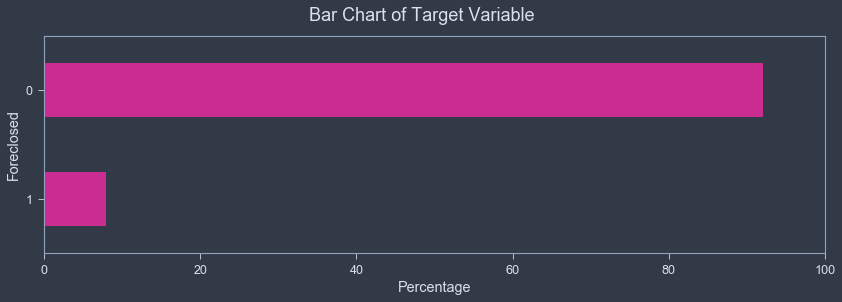

Frequency of Foreclosures
0    1143652
1     102847
Name: Foreclosed, dtype: int64

Percentage of Foreclosures
0    92
1     8
Name: Foreclosed, dtype: int32



In [17]:
# Create Target Variable with Merge
df = merge_df(df_acq, df_per)

print('\nThe number of features is:\n', df.shape[1], sep='')
print('\nThe number of observations is:\n', df.shape[0], sep='')
target_values(df['Foreclosed'], data=True)

In [101]:
# Clean Data
## Drop U.S. Terroritories due to missing data
df = df[df['Property State'] != 'PR']
df = df[df['Property State'] != 'GU']
df = df[df['Property State'] != 'VI']
    
## Drop high missing and impute on others
df = missing_treat(df)

pd.options.display.max_columns = None
df.head(10)

,Origination Channel,Bank,Original Interest Rate,Original Mortgage Amount,Original Loan Term,Original Date,Original Combined Loan-to-Value (CLTV),Single Borrower,Original Debt to Income Ratio,Credit Score,First Time Home Buyer,Loan Purpose,Property Type,Number of Units,Occupancy Type,Property State,Zip Code,Mortgage Insurance %,Product Type,Mortgage Insurance Type,Relocation Mortgage Indicator,Year,Quarter,Harmonized Credit Score,Median Household Income,Foreclosed
0,R,"PNC BANK, N.A.",6.250,137000,360,01/2007,56.0,0.0,37.0,741.0,N,C,SF,1,P,MI,486,0.0,FRM,0,N,be/D,oc,739.25,42311.760870,1
1,R,SUNTRUST MORTGAGE INC.,6.000,116000,360,02/2007,80.0,0.0,11.0,796.0,N,R,SF,1,S,GA,302,0.0,FRM,0,N,be/D,oc,787.50,42219.773389,0
2,C,"CITIMORTGAGE, INC.",6.375,58000,180,02/2007,78.0,0.0,30.0,710.0,N,R,SF,1,P,IN,465,0.0,FRM,0,N,be/D,oc,710.00,42413.046667,0
3,C,"BANK OF AMERICA, N.A.",6.125,353000,360,12/2006,80.0,0.0,28.0,778.0,N,R,SF,1,P,MA,21,0.0,FRM,0,N,be/D,oc,747.50,67582.456954,0
4,C,"GMAC MORTGAGE, LLC",5.875,385000,360,12/2006,70.0,0.0,50.0,720.0,N,C,SF,1,P,CA,917,0.0,FRM,0,N,be/D,oc,715.00,54329.865672,0
5,R,OTHER,6.250,117000,360,03/2007,90.0,0.0,41.0,753.0,N,P,SF,1,P,OH,449,17.0,FRM,1,N,be/D,oc,750.50,44413.833333,0
6,R,OTHER,5.750,200000,360,01/2007,46.0,0.0,25.0,674.0,N,C,SF,1,P,CT,60,0.0,FRM,0,N,be/D,oc,696.25,64481.844444,0
7,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.375,219000,360,12/2006,92.0,0.0,27.0,749.0,Y,P,PU,1,P,NC,282,0.0,FRM,0,N,be/D,oc,749.00,46100.575540,0
8,C,"CITIMORTGAGE, INC.",6.375,198000,360,12/2006,54.0,1.0,13.0,777.0,N,C,SF,1,S,CA,961,0.0,FRM,0,N,be/D,oc,777.00,47772.131148,0
9,R,OTHER,5.875,55000,180,03/2007,37.0,1.0,41.0,619.0,N,C,SF,1,P,AR,727,0.0,FRM,0,N,be/D,oc,619.00,44443.597792,0


In [ ]:
# Missing
(df.isna().sum() / df.shape[0] * 100).round(2)

# Foreclosure Descriptive Statistics

In [ ]:
def Foreclosure_Data(date1 = "", date2 = "", subset = "", df = df):
    # Subset by Date
    if (date1 == "" and date2 == ""):
        df_sub = df
    elif (date1 != "" and date2 != ""):
        date = pd.date_range(date1, date2)
        month_yr = np.array([])
        for i in range(len(date)): 
            month_yr = np.append( month_yr, str( str(date.month[i]) + '/' + str(date.year[i]) ) )
        month_yr = np.unique(month_yr)
        month_yr = np.char.zfill(month_yr, 7)
        df_sub = df[df['Original Date'].isin(month_yr)]
    elif (date2 == ""):
        df_sub = df[df['Original Date']==date1]
    elif (date1 == ""):
        df_sub = df[df['Original Date']==date2]
    
    # Subset by other variable
    if (date1 == "" and date2 == "" and subset != ""):
        df_sub = df[eval(subset)]
        
    # Foreclosures represented
    Foreclosed = ['Not Forclosed', 'Forclosed']
    Target = df_sub.groupby(['Foreclosed']).size().reset_index(name='Total')
    # Original Mortgage Amount
    ORM = df_sub.groupby(['Foreclosed']).agg({'Original Mortgage Amount': 'mean'}).round(2)
    # Credit Score
    CS = df_sub.groupby(['Foreclosed']).agg({'Harmonized Credit Score': 'mean'}).astype(int)
    # Original Debt to Income Ratio
    DTI = df_sub.groupby(['Foreclosed']).agg({'Original Debt to Income Ratio': 'mean'}).round(1)
    # First Time Home Buyer
    FT = df_sub[df_sub['First Time Home Buyer']=='Y'].groupby(['Foreclosed']).size().reset_index(name='Total')
    # Original Interest Rate
    IR = df_sub.groupby(['Foreclosed']).agg({'Original Interest Rate': 'mean'}).round(2)
    # Original Loan Term
    LT = df_sub.groupby(['Foreclosed']).agg({'Original Loan Term': 'mean'}).astype(int)
    # Original Combined Loan-to-Value (CLTV)
    CLTV = df_sub.groupby(['Foreclosed']).agg({'Original Combined Loan-to-Value (CLTV)': 'mean'}).round(1)
    # Single Borrower Ratio
    SBR = df_sub.groupby(['Foreclosed']).agg({'Single Borrower': 'mean'}).round(2)
    # Mortgage Insurance Type
    MIT = df_sub.groupby(['Foreclosed']).agg({'Mortgage Insurance Type': 'mean'}).round(2)
    # Mortgage Insurance %
    MIP = df_sub.groupby(['Foreclosed']).agg({'Mortgage Insurance %': 'mean'}).round(2)    
    # Median Household Income
    MHI = df_sub.groupby(['Foreclosed']).agg({'Median Household Income': 'mean'}).round(2)
    
    # Create Dataset
    df_new = pd.DataFrame({ 'Foreclosed': Foreclosed, 
                            'Foreclosed (%)': ((Target['Total'] / df_sub.shape[0]) * 100).round(1),
                            'Foreclosed (N)': df_sub.groupby(['Foreclosed']).size(),
                            'Mortgage Amount ($)': ORM['Original Mortgage Amount'].tolist(),
                            'Harmonized Credit Score': CS['Harmonized Credit Score'].tolist(),
                            'Debt to Income Ratio': DTI['Original Debt to Income Ratio'].tolist(),
                            'First Time Home Buyer (%)': ((FT['Total'] / Target['Total']) * 100).round(1).tolist(),
                            'Interest Rate': IR['Original Interest Rate'].tolist(),
                            'Loan Term': LT['Original Loan Term'].tolist(),
                            'Combined Loan-to-Value (CLTV)': CLTV['Original Combined Loan-to-Value (CLTV)'].tolist(),
                            'Single Borrower Ratio': SBR['Single Borrower'].tolist(),
                            'Mortgage Insurance Ratio': MIT['Mortgage Insurance Type'].tolist(),
                            'Mortgage Insurance %': MIP['Mortgage Insurance %'].tolist(),
                            'Estimated Household Income ($)': MHI['Median Household Income'].tolist()
                         })
    
    df_new = df_new.set_index('Foreclosed')
    return df_new

Foreclosed = Foreclosure_Data(subset = "df['Property State']=='FL'")
Foreclosed

# Bank Descriptive Statistics

In [ ]:
def Bank_Data(date1 = "", date2 = "", subset ="", df = df):
    # Subset by Date
    if (date1 == "" and date2 == ""):
        df_sub = df
    elif (date1 != "" and date2 != ""):
        date = pd.date_range(date1, date2)
        month_yr = np.array([])
        for i in range(len(date)): 
            month_yr = np.append( month_yr, str( str(date.month[i]) + '/' + str(date.year[i]) ) )
        month_yr = np.unique(month_yr)
        month_yr = np.char.zfill(month_yr, 7)
        df_sub = df[df['Original Date'].isin(month_yr)]
    elif (date2 == ""):
        df_sub = df[df['Original Date']==date1]
    elif (date1 == ""):
        df_sub = df[df['Original Date']==date2]
    
    # Subset by other variable
    if (date1 == "" and date2 == "" and subset != ""):
        df_sub = df[eval(subset)]
        
    # Banks represented
    Banks = df_sub.groupby(['Bank']).size().reset_index(name='Total')
    # Foreclosures
    Target = df_sub.groupby(['Bank']).agg({'Foreclosed': 'mean'})
    # Original Mortgage Amount
    ORM = df_sub.groupby(['Bank']).agg({'Original Mortgage Amount': 'mean'}).round(2)
    # Credit Score
    CS = df_sub.groupby(['Bank']).agg({'Credit Score': 'mean'}).astype(int)
    # Original Debt to Income Ratio
    DTI = df_sub.groupby(['Bank']).agg({'Original Debt to Income Ratio': 'mean'}).round(1)
    # First Time Home Buyer
    FT = df_sub[df_sub['First Time Home Buyer']=='Y'].groupby(['Bank']).size().reset_index(name='Total')
    # Original Interest Rate
    IR = df_sub.groupby(['Bank']).agg({'Original Interest Rate': 'mean'}).round(2)
    # Original Loan Term
    LT = df_sub.groupby(['Bank']).agg({'Original Loan Term': 'mean'}).astype(int)
    # Original Combined Loan-to-Value (CLTV)
    CLTV = df_sub.groupby(['Bank']).agg({'Original Combined Loan-to-Value (CLTV)': 'mean'}).round(1)
    # Single Borrower Ratio
    SBR = df_sub.groupby(['Bank']).agg({'Single Borrower': 'mean'}).round(2)
    # Mortgage Insurance Type
    MIT = df_sub.groupby(['Bank']).agg({'Mortgage Insurance Type': 'mean'}).round(2)
    # Mortgage Insurance %
    MIP = df_sub.groupby(['Bank']).agg({'Mortgage Insurance %': 'mean'}).round(2)     
    # Median Household Income
    MHI = df_sub.groupby(['Bank']).agg({'Median Household Income': 'mean'}).round(2)
    
    # Create Dataset
    df_new = pd.DataFrame({ 'Bank': Banks['Bank'], 
                            'Bank (%)': ((Banks['Total'] / df_sub.shape[0]) * 100).round(1),
                            'Bank (N)': Banks['Total'],
                            'Foreclosed (%)': ((Target['Foreclosed'] * 100).round(1)).tolist(), 
                            'Mortgage Amount ($)': ORM['Original Mortgage Amount'].tolist(),
                            'Credit Score': CS['Credit Score'].tolist(),
                            'Debt to Income Ratio': DTI['Original Debt to Income Ratio'].tolist(),
                            'First Time Home Buyer (%)': ((FT['Total'] / Banks['Total']) * 100).round(1).tolist(),
                            'Interest Rate': IR['Original Interest Rate'].tolist(),
                            'Loan Term': LT['Original Loan Term'].tolist(),
                            'Combined Loan-to-Value (CLTV)': CLTV['Original Combined Loan-to-Value (CLTV)'].tolist(),
                            'Single Borrower Ratio': SBR['Single Borrower'].tolist(),
                            'Mortgage Insurance Ratio': MIT['Mortgage Insurance Type'].tolist(),
                            'Mortgage Insurance %': MIP['Mortgage Insurance %'].tolist(),                           
                            'Median Household Income ($)': MHI['Median Household Income'].tolist()
                        })
    
    df_new = df_new.set_index("Bank")
    return df_new

Banks = Bank_Data()
Banks

In [ ]:
# Banks represented
Banks[['Bank (%)', 'Bank (N)', 'Foreclosed (%)']]

In [ ]:
def search_Banks(col, df = Banks, func = max, subset = True):
    print(col, func.__name__, "value")
    if (subset): cols = col
    else: cols = df.columns
    values = pd.DataFrame(df[cols][df[col] == func(df[col])])
    return values

search_Banks('Foreclosed (%)', func = max)

In [ ]:
month = [1,2,3]
for mnth in range(1, 13):

    yr = '2007'
    mnth = np.char.zfill(str(mnth), 2)
    print(str(mnth) + '/' + str(yr))
    Banks_mnth = Bank_Data(date1 = str(mnth) + '/' + str(yr))
    tbl = search_Banks('Foreclosed (%)', func = max, df = Banks_mnth[Banks_mnth['Bank (N)'] > 100])
    print(display(tbl[['Foreclosed (%)']]))
    print('')


for yr in range(2004, 2007):
    print('Year', yr)
    Banks_yr = Bank_Data(date1 = '01/' + str(yr), date2 = '12/' + str(yr))
    tbl = search_Banks('Foreclosed (%)', func = max, subset = False, df = Banks_yr[Banks_yr['Bank (N)'] > 100])
    print(display(tbl[['Foreclosed (%)', 'Bank (%)', 'Bank (N)']]))
    print('')
